## ElasticNet Logistic Regression

In [2]:
import sys
sys.path.append('../')
# pipeline functions
from dropkeeper import *
sc.settings.set_figure_params(dpi=80, color_map='viridis')

In [ ]:
# working
del sys.modules['dropkeeper']
from dropkeeper import *

### Load data and preprocess

In [3]:
s1 = sc.read_h5ad('../data/2771-AS-1-GCCAAT_S1.h5ad')
# see how many "good cells" are manually labeled (1)
s1.obs['manual_label'].value_counts()

0    5349
1    2715
Name: manual_label, dtype: int64

In [4]:
%%time
# preprocess data with recipe
recipe_dropkeeper(s1, X_final='raw_counts', mito_names='^mt-|^MT-', calc_metrics=True, n_hvgs=2000, target_sum=None)

Top 10 ambient genes have dropout rates between 0.14 and 3.56 percent
CPU times: user 9.53 s, sys: 2.19 s, total: 11.7 s
Wall time: 11.7 s


In [5]:
s1.var_names[s1.var.ambient]

Index(['Gm42418', 'mt-Atp6', 'mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1',
       'mt-Nd2', 'mt-Nd3', 'mt-Nd4'],
      dtype='object', name='index')

### Thresholding
Let's try employing automated threshold picking from [scikit-image](https://scikit-image.org/docs/dev/api/skimage.filters.html) to determine the cutoff between our __empty__ and __non-empty__ droplets.

In [7]:
s1_thresh = auto_thresh_obs(s1, method='otsu', obs_cols=['arcsinh_n_genes_by_counts','pct_counts_ambient'])

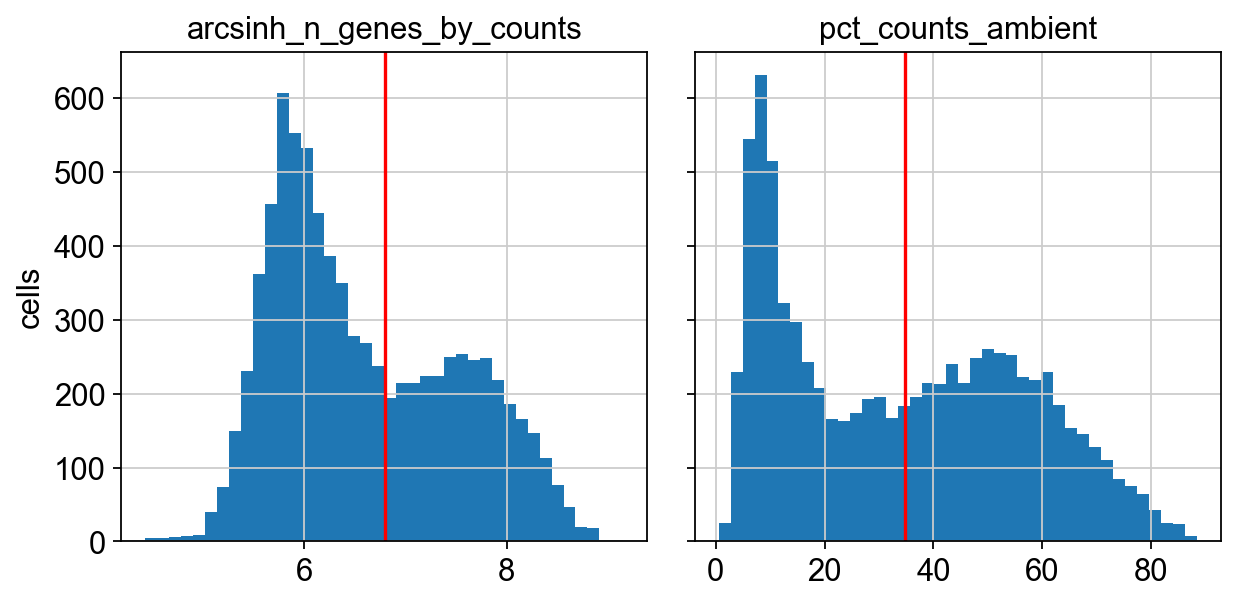

In [8]:
plot_thresh_obs(s1, s1_thresh)

---
### Use combination of the above 5 filters to "hard threshold" our dataset and compare to manual labels

In [9]:
%%time
filter_thresh_obs(s1, 
                  s1_thresh,
                  obs_cols=['arcsinh_n_genes_by_counts','pct_counts_ambient'], 
                  directions=['above','below'],
                  name='train'
                 )

CPU times: user 6.33 ms, sys: 1.08 ms, total: 7.41 ms
Wall time: 6.37 ms


#### Look at set differences with manual label:

In [10]:
from qc_test import set_diff

In [11]:
set_diff(s1, labels=['train','manual_label'])

2816 cells in train - 255 unique
2715 cells in manual_label - 154 unique


---
#### Train regression model on thresholded labels

In [106]:
l1_ratios = [0.1]
alphas = [0.001, 0.01]
n_splits = 3
seed = 18

In [97]:
# 3) cross-validation to choose alpha and l1_ratio values
%time splits = kfold_split_adata(s1, label="train", n_splits=n_splits, n_hvgs=2000, seed=seed, shuffle=True)

Splitting data into 3 folds for cross validation and feature-selecting on training sets . . .
CPU times: user 25.5 s, sys: 6.97 s, total: 32.5 s
Wall time: 34 s


In [107]:
%%time
print("Training classifier by {}-fold cross validation with alpha values: {} and regularization ratios: {}".format(n_splits, alphas, l1_ratios))
cv_scores = {"alpha":[], "l1_ratio":[], "score":[]}
params_list = list(itertools.chain.from_iterable([[x for x in zip(np.repeat(l1_ratios[y], len(alphas)), alphas)] for y in range(len(l1_ratios))]))
for params in params_list:
    rc = LogisticRegression(penalty="elasticnet", C=params[1], l1_ratio=params[0], solver="saga", random_state=seed, max_iter=1000)
    cv_scores["l1_ratio"].append(params[0])
    cv_scores["alpha"].append(params[1])
    cv_scores["score"].append(validator(splits, rc))

Training classifier by 3-fold cross validation with alpha values: [0.001, 0.01] and regularization ratios: [0.1]
CPU times: user 3min 25s, sys: 309 ms, total: 3min 25s
Wall time: 3min 23s


In [108]:
alpha_ = cv_scores["alpha"][cv_scores["score"].index(max(cv_scores["score"]))]  # choose alpha value
l1_ratio_ = cv_scores["l1_ratio"][cv_scores["score"].index(max(cv_scores["score"]))]  # choose l1 ratio
print("Chosen alpha value: {}; Chosen l1 ratio: {}".format(alpha_, l1_ratio_))

Chosen alpha value: 0.01; Chosen l1 ratio: 0.1


In [109]:
%%time
# 4) train final regression classifier
y = s1.obs["train"].copy(deep=True)  # training labels defined above
X = s1.layers["arcsinh_norm"][:, s1.var["highly_variable"] == True].copy()
rc = LogisticRegression(penalty="elasticnet", C=alpha_, l1_ratio=l1_ratio_, solver="saga", random_state=seed, max_iter=1000)
rc.fit(X, y)

CPU times: user 1min 21s, sys: 31 ms, total: 1min 21s
Wall time: 1min 21s


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.1, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='elasticnet',
                   random_state=18, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [110]:
# 5) use ridge model to assign scores and labels
print("Assigning scores and labels from model")
s1.obs["dropkeeper_score"] = rc.predict_proba(X)[:,1]
s1.obs["dropkeeper_label"] = rc.predict(X)

Assigning scores and labels from model


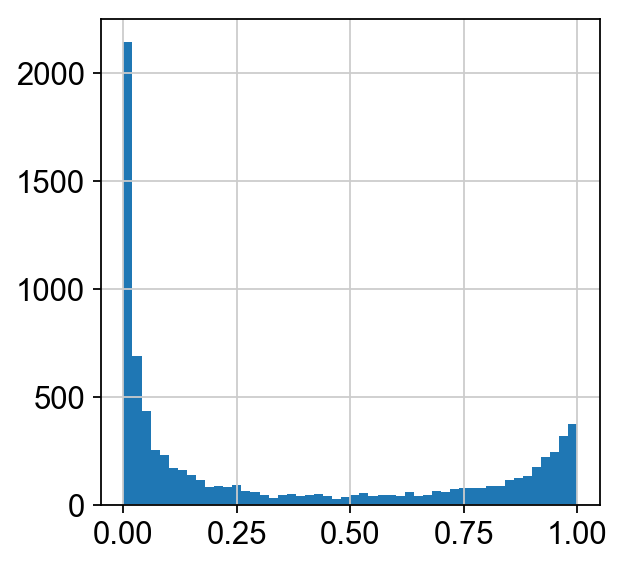

In [111]:
# distribution of scores should be bimodal at 0 and 1
_ = plt.hist(s1.obs['dropkeeper_score'], bins=50)

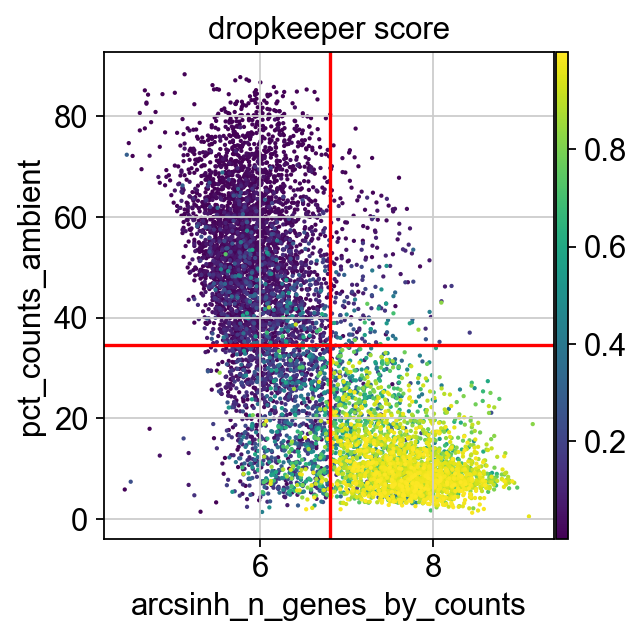

In [112]:
# look at probability scores from classifier
ax = sc.pl.scatter(adata=s1, y='pct_counts_ambient', x='arcsinh_n_genes_by_counts', color='dropkeeper_score', show=False)
ax.axvline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
ax.axhline(s1_thresh['pct_counts_ambient'], color='r')
plt.show()

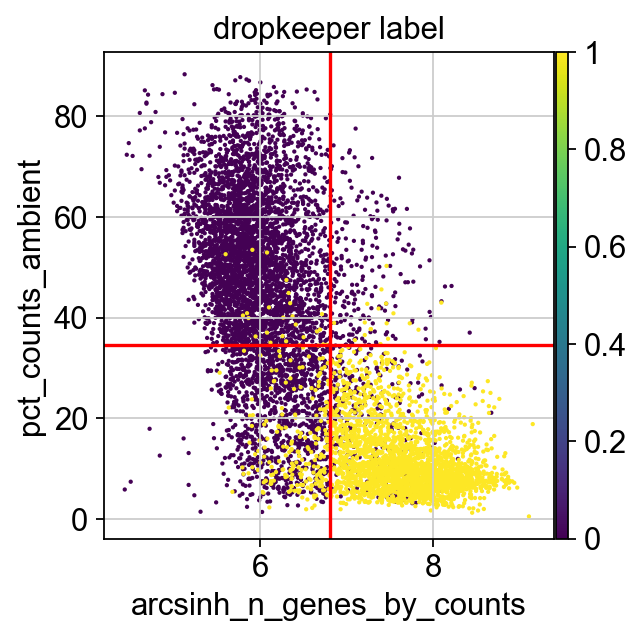

In [113]:
# look at probability scores from classifier
ax = sc.pl.scatter(adata=s1, y='pct_counts_ambient', x='arcsinh_n_genes_by_counts', color='dropkeeper_label', show=False)
ax.axvline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
ax.axhline(s1_thresh['pct_counts_ambient'], color='r')
plt.show()

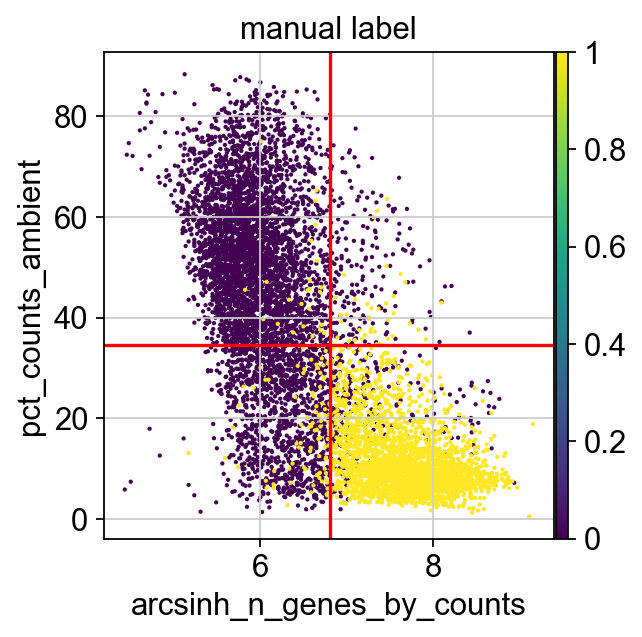

In [114]:
# look at probability scores from classifier
ax = sc.pl.scatter(adata=s1, y='pct_counts_ambient', x='arcsinh_n_genes_by_counts', color='manual_label', show=False)
ax.axvline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
ax.axhline(s1_thresh['pct_counts_ambient'], color='r')
plt.show()

In [115]:
set_diff(s1, labels=['dropkeeper_label','manual_label'])

2794 cells in dropkeeper_label - 405 unique
2715 cells in manual_label - 326 unique


In [74]:
import pandas as pd

In [116]:
coefs = pd.DataFrame(rc.coef_.squeeze(), index=s1.var_names[s1.var.highly_variable==1])
coefs = coefs.iloc[coefs[0].argsort()]

Text(0.5, 0, '')

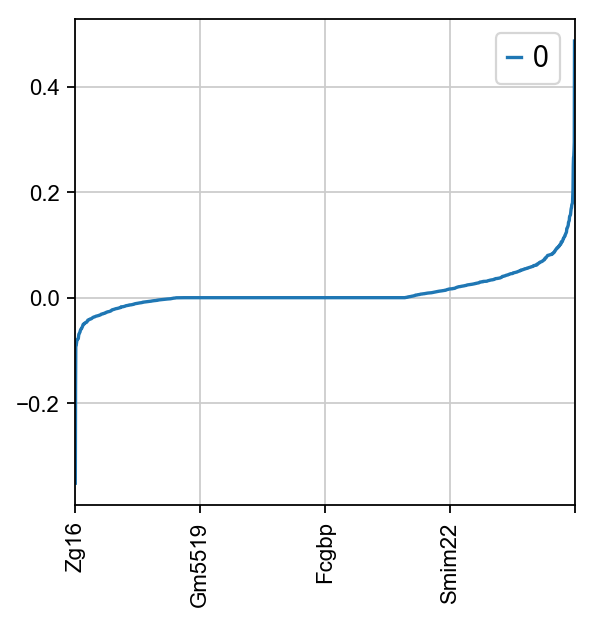

In [117]:
ax = coefs.plot(rot=90, fontsize=10)
ax.set_xlabel(None)